# MSCNN-BiLSTM-AE: Two-Stage Unsupervised NIDS

| | |
|---|---|
| **Stage 1** | Multi-Scale CNN Autoencoder (per-flow spatial features) |
| **Stage 2** | BiLSTM Autoencoder (temporal patterns on latent sequences) |
| **Training** | Benign CIC-IDS-2017 only |
| **Primary eval** | CSE-CIC-IDS-2018 (unseen) |
| **Secondary eval** | CIC-IDS-2017 all-label |

Jalankan tiap cell **secara berurutan**. Setiap cell menampilkan log progress.

In [22]:
# ============================================================
# CELL 1: Mount Drive & Clone Repo
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

import os

# --- CONFIG: Sesuaikan path ini ---
# Ganti YOUR_USERNAME dengan username GitHub kamu.
GITHUB_REPO = 'https://github.com/akwancakra/mscnn-lstm-ae-nids-28-feb.git'
PROJECT_ROOT = '/content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb'
# ----------------------------------

# Nama folder lokal otomatis diambil dari nama repo GitHub
REPO_NAME = GITHUB_REPO.rstrip('/').split('/')[-1].replace('.git', '')
REPO_DIR = f'/content/{REPO_NAME}'

if not os.path.isdir(REPO_DIR):
    !git clone {GITHUB_REPO} {REPO_DIR}
else:
    print(f'Repo sudah ada di {REPO_DIR}, pull latest...')
    !cd {REPO_DIR} && git pull

os.makedirs(PROJECT_ROOT, exist_ok=True)
print(f'\nProject root (Drive): {PROJECT_ROOT}')
print(f'Repo dir (local):     {REPO_DIR}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Repo sudah ada di /content/mscnn-lstm-ae-nids-28-feb, pull latest...
Already up to date.

Project root (Drive): /content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb
Repo dir (local):     /content/mscnn-lstm-ae-nids-28-feb


In [23]:
# ============================================================
# CELL 2: Install Dependencies
# ============================================================
!pip install -q pyyaml joblib tqdm seaborn scikit-learn scipy pyarrow
print('\nDependencies installed.')


Dependencies installed.


In [24]:
# ============================================================
# CELL 3: Setup Path & Logging
# ============================================================
import sys
import os
import time
import logging
from pathlib import Path

# Gunakan REPO_DIR yang sudah didefinisikan di Cell 1.
# Jika belum ada (misal langsung lompat ke cell ini), hitung lagi dari GITHUB_REPO.
try:
    REPO_DIR
except NameError:
    REPO_NAME = GITHUB_REPO.rstrip('/').split('/')[-1].replace('.git', '')
    REPO_DIR = f'/content/{REPO_NAME}'
if REPO_DIR not in sys.path:
    sys.path.insert(0, REPO_DIR)

os.chdir(REPO_DIR)
print(f'Working dir: {os.getcwd()}')

from src.utils import setup_logging, set_global_seed, resolve_paths, get_path, ensure_dir, save_json, save_npz, load_npz, setup_gpu

setup_logging('INFO')
logger = logging.getLogger('colab_runner')
logger.info('Logging configured — all progress will be shown below each cell.')

# Verify source tree
src_dir = os.path.join(REPO_DIR, 'src')
for root, dirs, files in os.walk(src_dir):
    level = root.replace(src_dir, '').count(os.sep)
    indent = '  ' * level
    print(f'{indent}{os.path.basename(root)}/')
    for f in sorted(files):
        print(f'{indent}  {f}')

Working dir: /content/mscnn-lstm-ae-nids-28-feb
2026-02-28 07:15:48 | INFO | colab_runner | Logging configured — all progress will be shown below each cell.
src/
  __init__.py
  config.yaml
  main.py
  utils.py
  evaluation/
    __init__.py
    metrics.py
    visualization.py
  data/
    __init__.py
    domain_shift.py
    loader.py
    preprocessing.py
    windowing.py
    __pycache__/
      __init__.cpython-312.pyc
      loader.cpython-312.pyc
  __pycache__/
    __init__.cpython-312.pyc
    utils.cpython-312.pyc
  model/
    __init__.py
    lstm_ae.py
    mscnn_ae.py
  training/
    __init__.py
    threshold.py
    trainer.py


In [ ]:
# ============================================================
# CELL 3b: GPU Setup
# ============================================================
# Run after Cell 4 (Config) so cfg exists; otherwise run with None for defaults.
try:
    setup_gpu(cfg)
except NameError:
    setup_gpu(None)
print('GPU setup done.')

In [ ]:
# ============================================================
# CELL 4: Configuration
# ============================================================
# Project root: code/output, processed data, models, results
PROJECT_ROOT = '/content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb'
# Raw data root: folder yang berisi subfolder raw/CIC-IDS2017 dan raw/CSE-CIC-IDS2018
DATA_ROOT = '/content/drive/MyDrive/nids-data'

CONFIG = {
    'runtime': {
        'colab_mode': True,
        'drive_root': PROJECT_ROOT,
        'data_root': DATA_ROOT,
        'random_seed': 42,
        'skip_preprocessing': True,
        'gpu_memory_growth': True,
    },
    'paths': {
        'data_raw_cic': 'raw/CIC-IDS2017',
        'data_raw_cse': 'raw/CSE-CIC-IDS2018',
        'data_processed': 'data/processed',
        'models_dir': 'models',
        'results_dir': 'results',
    },
    'preprocessing': {
        'drop_columns': ['Flow ID'],
        'session_columns': {
            'src_ip': ['Source IP', 'Src IP'],
            'dst_ip': ['Destination IP', 'Dst IP'],
            'protocol': ['Protocol'],
            'timestamp': ['Timestamp'],
        },
        'label_candidates': ['Label', 'label', 'Class'],
        'benign_label': 'BENIGN',
        'scaler': 'robust',
        'post_scale_clip': 5.0,
        'fillna_strategy': 'median',
        'feature_filter': {
            'nzv_threshold': 1e-5,
            'corr_threshold': 0.98,
        },
        'chunksize': 50000,
    },
    'windowing': {
        'mode': 'auto',
        'window_size': 5,
        'min_session_length': 3,
        'fallback_mode': 'per_flow',
    },
    'stage1': {
        'latent_dim': 'auto',
        'conv_filters': [32, 32, 32],
        'conv_kernels': [1, 3, 5],
        'reduction_filters': 64,
        'batch_size': 256,
        'epochs': 100,
        'learning_rate': 0.001,
        'clipnorm': 1.0,
        'early_stopping_patience': 10,
        'reduce_lr_patience': 5,
        'reduce_lr_factor': 0.5,
        'min_lr': 1e-6,
    },
    'stage2': {
        'temporal_latent_dim': 'auto',
        'lstm_units': 32,
        'dropout': 0.3,
        'batch_size': 256,
        'epochs': 100,
        'learning_rate': 0.001,
        'clipnorm': 1.0,
        'early_stopping_patience': 10,
        'reduce_lr_patience': 5,
        'reduce_lr_factor': 0.5,
        'min_lr': 1e-6,
    },
    'scoring': {
        'alpha': 0.5,
        'alpha_degenerate': 0.7,
    },
    'threshold': {
        'zscore_k': [1.5, 2.0, 2.5, 3.0],
        'percentiles': [95, 97, 99, 99.5],
        'iqr_k': [1.5, 2.0, 3.0],
        'target_fpr': 0.05,
    },
    'split': {
        'val_size': 0.2,
        'split_by_file': True,
    },
}

cfg = resolve_paths(CONFIG.copy())
# Override raw data paths to DATA_ROOT (agar jalan meskipun repo lama)
from pathlib import Path
if DATA_ROOT:
    cfg['_resolved_paths']['data_raw_cic'] = str(Path(DATA_ROOT) / 'raw/CIC-IDS2017')
    cfg['_resolved_paths']['data_raw_cse'] = str(Path(DATA_ROOT) / 'raw/CSE-CIC-IDS2018')
set_global_seed(42)

models_dir = str(ensure_dir(get_path(cfg, 'models_dir')))
results_dir = str(ensure_dir(get_path(cfg, 'results_dir')))
processed_dir = str(ensure_dir(get_path(cfg, 'data_processed')))

pp_cfg = cfg.get('preprocessing', {})
split_cfg = cfg.get('split', {})
window_cfg = cfg.get('windowing', {})
scoring_cfg = cfg.get('scoring', {})
benign_label = pp_cfg.get('benign_label', 'BENIGN')

logger.info('Config loaded. Paths resolved.')
logger.info('  project root:  %s', cfg['runtime']['drive_root'])
logger.info('  data root:     %s', cfg['runtime'].get('data_root', '(same as project)'))
logger.info('  data_raw_cic:  %s', get_path(cfg, 'data_raw_cic'))
logger.info('  data_raw_cse:  %s', get_path(cfg, 'data_raw_cse'))
logger.info('  models_dir:    %s', models_dir)
logger.info('  results_dir:   %s', results_dir)
logger.info('  processed_dir: %s', processed_dir)
setup_gpu(cfg)
print('\nConfig OK.')

2026-02-28 07:15:48 | INFO | colab_runner | Config loaded. Paths resolved.
2026-02-28 07:15:48 | INFO | colab_runner |   project root:  /content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb
2026-02-28 07:15:48 | INFO | colab_runner |   data root:     /content/drive/MyDrive/nids-data
2026-02-28 07:15:48 | INFO | colab_runner |   data_raw_cic:  /content/drive/MyDrive/nids-data/raw/CIC-IDS2017
2026-02-28 07:15:48 | INFO | colab_runner |   data_raw_cse:  /content/drive/MyDrive/nids-data/raw/CSE-CIC-IDS2018
2026-02-28 07:15:48 | INFO | colab_runner |   models_dir:    /content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb/models
2026-02-28 07:15:48 | INFO | colab_runner |   results_dir:   /content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb/results
2026-02-28 07:15:48 | INFO | colab_runner |   processed_dir: /content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb/data/processed

Config OK.


In [26]:
# ============================================================
# CELL 5: Discover Datasets & Compute Shared Features
# ============================================================
import numpy as np
import pandas as pd

from src.data.loader import list_csv_files, compute_shared_features

t0 = time.time()

cic_files = list_csv_files(get_path(cfg, 'data_raw_cic'))
cse_files = list_csv_files(get_path(cfg, 'data_raw_cse'))

print(f'CIC-IDS-2017: {len(cic_files)} CSV files')
for f in cic_files:
    print(f'  {f.name}')

print(f'\nCSE-CIC-IDS-2018: {len(cse_files)} CSV files')
for f in cse_files:
    print(f'  {f.name}')

assert len(cic_files) > 0, f'No CIC CSV files found in {get_path(cfg, "data_raw_cic")}'
assert len(cse_files) > 0, f'No CSE CSV files found in {get_path(cfg, "data_raw_cse")}'

drop_columns = pp_cfg.get('drop_columns', ['Flow ID'])
label_candidates = pp_cfg.get('label_candidates', ['Label'])
session_cfg = pp_cfg.get('session_columns', {})

shared_features, cic_label, cse_label, cse_mapper = compute_shared_features(
    cic_files, cse_files, drop_columns, label_candidates,
)

logger.info('Shared features: %d', len(shared_features))
logger.info('CIC label col: %s', cic_label)
logger.info('CSE label col: %s', cse_label)
logger.info('CSE column mapper: %d mappings', len(cse_mapper))
logger.info('Cell completed in %.1fs', time.time() - t0)

2026-02-28 07:15:48 | INFO | src.data.loader | Found 8 CSV files in /content/drive/MyDrive/nids-data/raw/CIC-IDS2017
2026-02-28 07:15:48 | INFO | src.data.loader | Found 3 CSV files in /content/drive/MyDrive/nids-data/raw/CSE-CIC-IDS2018
CIC-IDS-2017: 8 CSV files
  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  Friday-WorkingHours-Morning.pcap_ISCX.csv
  Monday-WorkingHours.pcap_ISCX.csv
  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  Tuesday-WorkingHours.pcap_ISCX.csv
  Wednesday-workingHours.pcap_ISCX.csv

CSE-CIC-IDS-2018: 3 CSV files
  02-14-2018.csv
  02-15-2018.csv
  02-16-2018.csv
2026-02-28 07:15:49 | INFO | src.data.loader | Feature counts: CIC=78, CSE=79, shared=59
2026-02-28 07:15:49 | INFO | colab_runner | Shared features: 59
2026-02-28 07:15:49 | INFO | colab_runner | CIC label col: Label
2026-02-28 07:15:49 | INFO | colab_runner | CSE label c

In [27]:
# ============================================================
# CELL 6: Load Benign CIC-2017 & Split Train/Val
# ============================================================
from src.data.preprocessing import load_and_prepare_benign_train

t0 = time.time()
skip_preprocessing = cfg['runtime'].get('skip_preprocessing', False)

if not skip_preprocessing:
    logger.info('Loading benign CIC-2017 data...')
    X_train_raw, X_val_raw, meta_train, meta_val = load_and_prepare_benign_train(
        cic_files, shared_features, cic_label, benign_label, session_cfg,
        chunksize=pp_cfg.get('chunksize', 50000),
        val_size=split_cfg.get('val_size', 0.2),
        split_by_file=split_cfg.get('split_by_file', True),
    )
    logger.info('Benign train: %d samples, %d features', len(X_train_raw), X_train_raw.shape[1])
    logger.info('Benign val:   %d samples, %d features', len(X_val_raw), X_val_raw.shape[1])
    logger.info('Meta train:   %s', list(meta_train.columns))
    logger.info('Session IDs unique (train): %d', meta_train['session_id'].nunique())
else:
    logger.info('Skipping raw data load; cache will be loaded in next cell.')
logger.info('Cell completed in %.1fs', time.time() - t0)

2026-02-28 07:15:49 | INFO | colab_runner | Loading benign CIC-2017 data...
2026-02-28 07:15:49 | INFO | src.data.preprocessing | File-level split: 7 train files, 1 val files
2026-02-28 07:15:49 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip', 'protocol']. Using per-flow mode.
2026-02-28 07:15:49 | WARNING | src.data.loader | No timestamp column found, using row index as proxy.
2026-02-28 07:15:50 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip', 'protocol']. Using per-flow mode.
2026-02-28 07:15:50 | WARNING | src.data.loader | No timestamp column found, using row index as proxy.
2026-02-28 07:15:50 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip', 'protocol']. Using per-flow mode.
2026-02-28 07:15:50 | WARNING | src.data.loader | No timestamp column found, using row index as proxy.
2026-02-28 07:15:51 | WARNING | src.data.loader | Cannot build sessions — miss

In [28]:
# ============================================================
# CELL 7: Fit Preprocessing Pipeline & Transform
# ============================================================
from src.data.preprocessing import PreprocessingPipeline

t0 = time.time()
processed_path = Path(processed_dir)
cache_npz_path = processed_path / 'train_val_2d.npz'
meta_train_path = processed_path / 'meta_train.parquet'
meta_val_path = processed_path / 'meta_val.parquet'

if skip_preprocessing:
    logger.info('Loading cached preprocessing...')
    pipeline = PreprocessingPipeline(cfg).load(processed_path / 'pipeline.joblib')
    cache = load_npz(cache_npz_path)
    X_train = cache['X_train']
    X_val = cache['X_val']
    meta_train = pd.read_parquet(meta_train_path)
    meta_val = pd.read_parquet(meta_val_path)
    logger.info('Loaded cached: X_train %s, X_val %s', X_train.shape, X_val.shape)
else:
    logger.info('Fitting preprocessing pipeline on benign train...')
    pipeline = PreprocessingPipeline(cfg)
    pipeline.fit(X_train_raw, shared_features)
    pipeline.save(processed_path / 'pipeline.joblib')
    logger.info('Features: %d original -> %d after filtering', pipeline.n_features_original, pipeline.n_features_final)
    logger.info('2D reshape: (%d, %d)', pipeline.nx, pipeline.ny)
    logger.info('Latent dim (Stage 1 bottleneck): %d', pipeline.latent_dim)
    logger.info('Compression ratio: %.1fx', (pipeline.nx * pipeline.ny) / pipeline.latent_dim)
    logger.info('Final features: %s', pipeline.feature_names[:10])
    if len(pipeline.feature_names) > 10:
        logger.info('  ... and %d more', len(pipeline.feature_names) - 10)
    logger.info('Transforming train & val...')
    X_train = pipeline.transform(X_train_raw, reshape_2d=True)
    X_val = pipeline.transform(X_val_raw, reshape_2d=True)
    save_npz(cache_npz_path, X_train=X_train, X_val=X_val)
    meta_train.to_parquet(meta_train_path, index=False)
    meta_val.to_parquet(meta_val_path, index=False)
    logger.info('Saved cache: train_val_2d.npz, meta_train/val.parquet')

logger.info('X_train shape: %s', X_train.shape)
logger.info('X_val shape:   %s', X_val.shape)
logger.info('X_train range: [%.4f, %.4f]', X_train.min(), X_train.max())
logger.info('Cell completed in %.1fs', time.time() - t0)

2026-02-28 07:16:12 | INFO | colab_runner | Fitting preprocessing pipeline on benign train...
2026-02-28 07:16:13 | INFO | src.data.preprocessing | Imputer fit: 2/59 features have NaN values
2026-02-28 07:16:14 | INFO | src.data.preprocessing | NZV filter: dropping 2 features (var < 1e-05)
2026-02-28 07:16:25 | INFO | src.data.preprocessing | Correlation filter: dropping 12 features (corr > 0.98)
2026-02-28 07:16:26 | INFO | src.data.preprocessing | Features: 59 original -> 45 after filtering
2026-02-28 07:16:28 | INFO | src.data.preprocessing | RobustScaler fit on 1833066 samples, 45 features
2026-02-28 07:16:28 | INFO | src.data.preprocessing | 2D reshape: (45 features) -> (9 x 5), latent_dim=7
2026-02-28 07:16:28 | INFO | src.data.preprocessing | Pipeline saved to /content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb/data/processed/pipeline.joblib
2026-02-28 07:16:28 | INFO | colab_runner | Features: 59 original -> 45 after filtering
2026-02-28 07:16:28 | INFO | colab_runner | 2D reshape

2026-02-28 07:16:30 | INFO | colab_runner | Starting domain shift analysis...
2026-02-28 07:16:30 | INFO | colab_runner | Loading CSE-2018 data for shift comparison...
2026-02-28 07:16:31 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.
2026-02-28 07:16:31 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:31 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9
/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:31 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:32 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:32 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:32 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:33 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:33 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:34 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:34 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:35 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:35 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:36 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:36 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:37 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:37 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:37 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:38 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:38 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:39 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:40 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:40 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:41 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:41 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:42 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:42 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:43 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:43 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:44 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:44 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:44 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:45 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:45 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:46 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:46 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:46 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:47 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:47 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:48 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:48 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:48 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:49 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.
2026-02-28 07:16:49 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9
/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:50 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:50 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:50 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:51 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:51 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:51 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:52 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:52 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:52 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:53 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:53 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:54 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:54 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:54 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:54 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:55 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:55 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:56 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.
2026-02-28 07:16:56 | WARNING | src.data.loader | Timestamp parsing failed, using row index as proxy.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:56 | WARNING | src.data.loader | Cannot build sessions — missing columns: ['src_ip', 'dst_ip']. Using per-flow mode.


/content/mscnn-lstm-ae-nids-28-feb/src/data/loader.py:149: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ts_numeric = pd.to_datetime(ts_raw).astype(np.int64) // 10**9


2026-02-28 07:16:59 | INFO | src.data.preprocessing | Loaded 3145725 samples (45 features) from 3 files
2026-02-28 07:17:00 | INFO | colab_runner | CSE-2018 total: 3145725, benign: 2110475, attack: 1035250


/content/mscnn-lstm-ae-nids-28-feb/src/data/preprocessing.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace([np.inf, -np.inf], np.nan)


2026-02-28 07:17:01 | INFO | colab_runner | Computing KS-test per feature...
2026-02-28 07:17:01 | INFO | src.data.domain_shift | Domain shift: 41/45 features significantly different (p<0.01), 2 with KS>0.3


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


2026-02-28 07:17:02 | INFO | src.data.domain_shift | Domain shift plot saved to /content/drive/MyDrive/nids-mscnn-lstm-ae-28-feb/results/domain_shift.png
2026-02-28 07:17:02 | INFO | colab_runner | Domain shift summary:
2026-02-28 07:17:02 | INFO | colab_runner |   Features with significant shift (p<0.01): 41/45
2026-02-28 07:17:02 | INFO | colab_runner |   High shift (KS>0.3): 2
2026-02-28 07:17:02 | INFO | colab_runner |   Mean KS: 0.1374, Max KS: 0.3212
2026-02-28 07:17:02 | INFO | colab_runner |   Top 5 shifted features:
2026-02-28 07:17:02 | INFO | colab_runner |     Fwd Header Length: KS=0.3212
2026-02-28 07:17:02 | INFO | colab_runner |     Bwd Header Length: KS=0.3015
2026-02-28 07:17:02 | INFO | colab_runner |     Bwd Packets/s: KS=0.2646
2026-02-28 07:17:02 | INFO | colab_runner |     Flow IAT Max: KS=0.2290
2026-02-28 07:17:02 | INFO | colab_runner |     Packet Length Mean: KS=0.2214


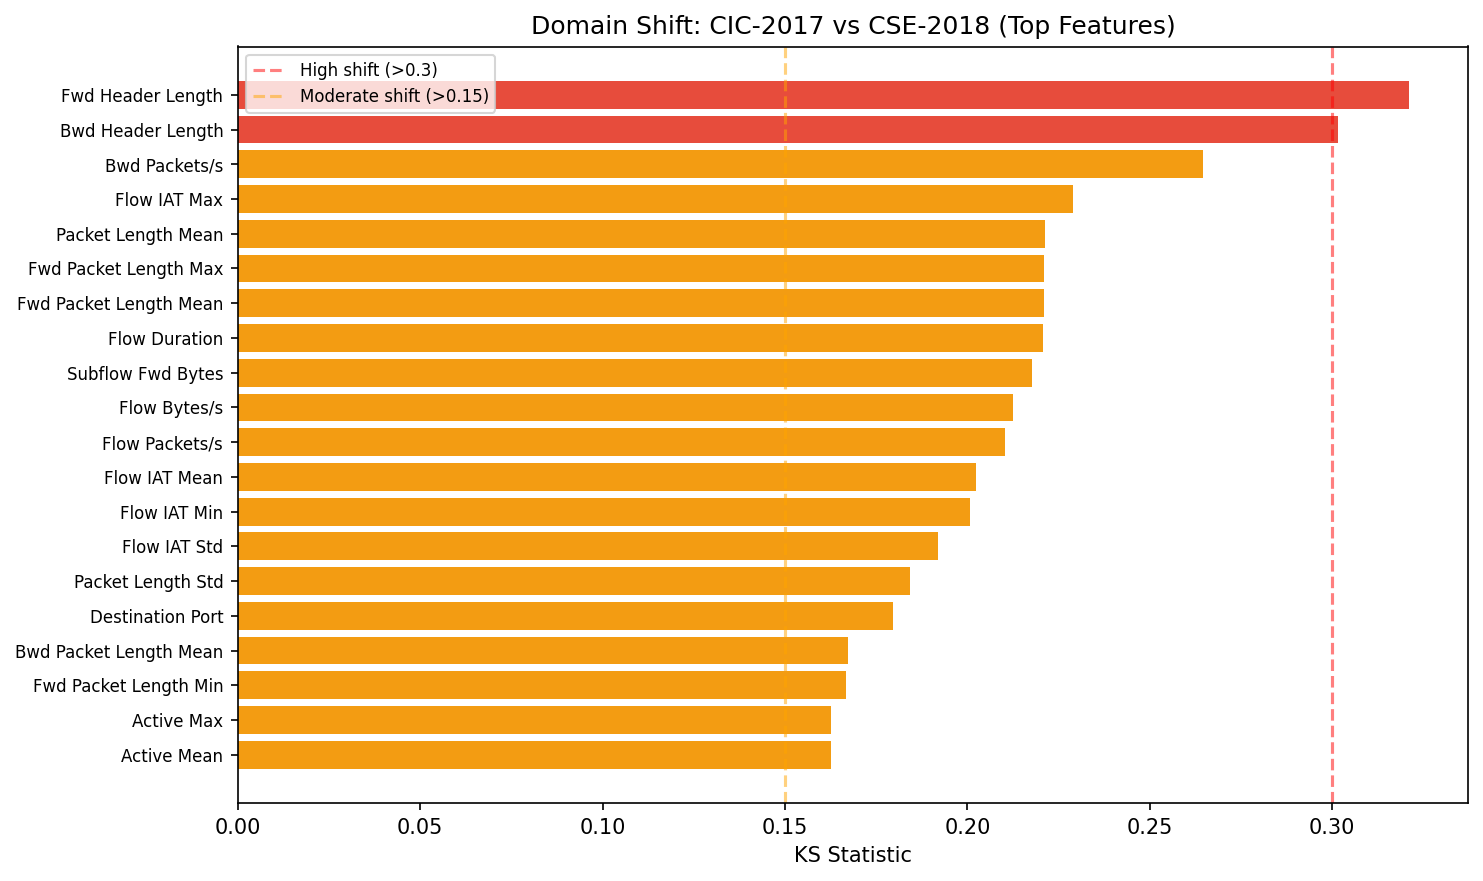


Top 10 features by KS statistic:


,feature,ks_statistic,p_value,mean_source,mean_target,std_source,std_target
0,Fwd Header Length,0.3212,9.881313e-324,1.214867,0.362253,2.145286,1.682816
1,Bwd Header Length,0.3015,9.881313e-324,1.171620,0.536273,2.148627,1.697039
2,Bwd Packets/s,0.2646,4.000981e-308,0.122310,0.352812,0.601639,1.042923
3,Flow IAT Max,0.2290,3.394932e-230,2.032995,1.517286,2.407435,2.195074
4,Packet Length Mean,0.2214,4.523223e-215,0.818661,0.222499,1.667807,1.095090
5,Fwd Packet Length Max,0.2211,1.744365e-214,1.697086,1.113969,2.383475,2.169061
6,Fwd Packet Length Mean,0.2211,1.744365e-214,0.479356,0.204229,1.357753,1.101386
7,Flow Duration,0.2208,6.714360e-214,2.045516,1.637055,2.386706,2.267759
8,Subflow Fwd Bytes,0.2176,1.046683e-207,1.557733,1.031305,2.249051,2.088994
9,Flow Bytes/s,0.2125,4.973916e-198,0.624611,0.347349,1.554709,0.844925


2026-02-28 07:17:02 | INFO | colab_runner | Cell completed in 31.7s


In [29]:
# ============================================================
# CELL 8: Domain Shift Analysis (CIC vs CSE)
# ============================================================
from src.data.preprocessing import load_all_labeled
from src.data.domain_shift import ks_test_per_feature, plot_domain_shift, summarize_shift
from src.evaluation.metrics import binary_labels
from IPython.display import Image, display

t0 = time.time()
logger.info('Starting domain shift analysis...')

X_val_flat = X_val.reshape(len(X_val), -1)[:, :pipeline.n_features_final]
domain_shift_report = {}

try:
    logger.info('Loading CSE-2018 data for shift comparison...')
    X_cse_raw, y_cse_all, meta_cse = load_all_labeled(
        cse_files, pipeline.feature_names, cse_label, session_cfg,
        column_mapper=cse_mapper, chunksize=pp_cfg.get('chunksize', 50000),
    )
    cse_benign_mask = binary_labels(y_cse_all, benign_label) == 0
    logger.info('CSE-2018 total: %d, benign: %d, attack: %d',
                len(y_cse_all), cse_benign_mask.sum(), (~cse_benign_mask).sum())

    X_cse_benign_scaled = pipeline.transform(
        X_cse_raw[cse_benign_mask].head(50000), reshape_2d=False,
    )

    logger.info('Computing KS-test per feature...')
    ks_df = ks_test_per_feature(
        X_val_flat[:50000], X_cse_benign_scaled[:50000],
        pipeline.feature_names,
    )

    shift_plot = str(Path(results_dir) / 'domain_shift.png')
    plot_domain_shift(ks_df, save_path=shift_plot)
    domain_shift_report = summarize_shift(ks_df)
    save_json(Path(results_dir) / 'domain_shift.json', domain_shift_report)
    ks_df.to_csv(Path(results_dir) / 'domain_shift_features.csv', index=False)

    logger.info('Domain shift summary:')
    logger.info('  Features with significant shift (p<0.01): %d/%d',
                domain_shift_report['n_significant_p001'], domain_shift_report['n_features'])
    logger.info('  High shift (KS>0.3): %d', domain_shift_report['n_high_shift_ks03'])
    logger.info('  Mean KS: %.4f, Max KS: %.4f',
                domain_shift_report['mean_ks'], domain_shift_report['max_ks'])
    logger.info('  Top 5 shifted features:')
    for item in domain_shift_report['top5_shifted']:
        logger.info('    %s: KS=%.4f', item['feature'], item['ks_statistic'])

    display(Image(filename=shift_plot, width=700))
    print('\nTop 10 features by KS statistic:')
    display(ks_df.head(10))

except Exception as e:
    logger.warning('Domain shift analysis failed: %s', e)
    domain_shift_report = {'error': str(e)}

logger.info('Cell completed in %.1fs', time.time() - t0)

In [30]:
# ============================================================
# CELL 9: Train Stage 1 — MSCNN-AE
# ============================================================
from src.training.trainer import train_stage1, extract_latent_vectors, compute_stage1_errors

t0 = time.time()
logger.info('=' * 60)
logger.info('STAGE 1: MSCNN-AE TRAINING')
logger.info('=' * 60)
logger.info('Input shape: %s', X_train.shape)
logger.info('Batch size: %d, Max epochs: %d',
            cfg['stage1']['batch_size'], cfg['stage1']['epochs'])

s1_model, s1_encoder, s1_history = train_stage1(
    X_train, X_val, cfg, models_dir, results_dir,
)

logger.info('Stage 1 training complete:')
logger.info('  Total params:    %d', s1_model.count_params())
logger.info('  Epochs trained:  %d', len(s1_history.history['loss']))
logger.info('  Final train loss: %.6f', s1_history.history['loss'][-1])
logger.info('  Final val loss:   %.6f', s1_history.history['val_loss'][-1])
logger.info('  Best val loss:    %.6f', min(s1_history.history['val_loss']))

print('\nModel summary:')
s1_model.summary()

# Show training curves
curves_path = str(Path(results_dir) / 'stage1_training_curves.png')
if os.path.exists(curves_path):
    display(Image(filename=curves_path, width=700))

logger.info('Cell completed in %.1fs', time.time() - t0)

2026-02-28 07:17:02 | INFO | colab_runner | ============================================================
2026-02-28 07:17:02 | INFO | colab_runner | STAGE 1: MSCNN-AE TRAINING
2026-02-28 07:17:02 | INFO | colab_runner | ============================================================
2026-02-28 07:17:02 | INFO | colab_runner | Input shape: (1833066, 9, 5, 1)
2026-02-28 07:17:02 | INFO | colab_runner | Batch size: 256, Max epochs: 100
2026-02-28 07:17:02 | INFO | src.model.mscnn_ae | MSCNN-AE: input=(9,5,1), latent=7, compression=6.4x, params=115528
2026-02-28 07:17:02 | INFO | src.training.trainer | Stage 1 training: 1833066 train, 440031 val, batch=256, max_epochs=100
Epoch 1/100


ValueError: Dimensions must be equal, but are 9 and 8 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, MSCNN_AE_1/output_1/Add)' with input shapes: [?,9,5,1], [?,8,4,1].

In [ ]:
# ============================================================
# CELL 10: Extract Latent Vectors & Stage 1 Errors
# ============================================================
t0 = time.time()
logger.info('Extracting latent vectors from Stage 1 encoder...')

latent_train = extract_latent_vectors(s1_encoder, X_train)
latent_val = extract_latent_vectors(s1_encoder, X_val)

logger.info('Latent train: %s', latent_train.shape)
logger.info('Latent val:   %s', latent_val.shape)
logger.info('Latent stats (train): mean=%.4f, std=%.4f, min=%.4f, max=%.4f',
            latent_train.mean(), latent_train.std(), latent_train.min(), latent_train.max())

logger.info('Computing Stage 1 reconstruction errors...')
err_s1_train = compute_stage1_errors(s1_model, X_train)
err_s1_val = compute_stage1_errors(s1_model, X_val)

logger.info('Stage 1 error stats:')
logger.info('  Train: mean=%.6f, std=%.6f, p95=%.6f, p99=%.6f',
            err_s1_train.mean(), err_s1_train.std(),
            np.percentile(err_s1_train, 95), np.percentile(err_s1_train, 99))
logger.info('  Val:   mean=%.6f, std=%.6f, p95=%.6f, p99=%.6f',
            err_s1_val.mean(), err_s1_val.std(),
            np.percentile(err_s1_val, 95), np.percentile(err_s1_val, 99))

save_npz(Path(processed_dir) / 'latent_train.npz', latent=latent_train, errors=err_s1_train)
save_npz(Path(processed_dir) / 'latent_val.npz', latent=latent_val, errors=err_s1_val)
logger.info('Latent vectors & errors saved.')
logger.info('Cell completed in %.1fs', time.time() - t0)

In [ ]:
# ============================================================
# CELL 11: Session Analysis & Windowing
# ============================================================
from src.data.windowing import analyze_session_lengths, create_windows, plot_session_lengths

t0 = time.time()
logger.info('=' * 60)
logger.info('SESSION ANALYSIS & WINDOWING')
logger.info('=' * 60)

session_stats_train = analyze_session_lengths(meta_train)

logger.info('Session analysis results:')
for k, v in session_stats_train.items():
    logger.info('  %s: %s', k, v)

sess_plot = str(Path(results_dir) / 'session_lengths.png')
plot_session_lengths(meta_train, save_path=sess_plot)
if os.path.exists(sess_plot):
    display(Image(filename=sess_plot, width=700))

logger.info('Creating windows for train set...')
windows_train, _, eff_W = create_windows(
    latent_train, meta_train, session_stats_train, window_cfg,
)
logger.info('Creating windows for val set...')
windows_val, _, _ = create_windows(
    latent_val, meta_val, session_stats_train, window_cfg,
)

logger.info('Effective window size: W=%d', eff_W)
logger.info('Windows train: %s', windows_train.shape)
logger.info('Windows val:   %s', windows_val.shape)
logger.info('Cell completed in %.1fs', time.time() - t0)

In [ ]:
# ============================================================
# CELL 12: Train Stage 2 — BiLSTM/Dense-AE
# ============================================================
from src.training.trainer import train_stage2, compute_stage2_errors

t0 = time.time()
stage2_type = 'BiLSTM-AE' if eff_W > 1 else 'Dense-AE (W=1 fallback)'
logger.info('=' * 60)
logger.info('STAGE 2: %s TRAINING', stage2_type)
logger.info('=' * 60)
logger.info('Input shape: %s', windows_train.shape)
logger.info('Batch size: %d, Max epochs: %d',
            cfg['stage2']['batch_size'], cfg['stage2']['epochs'])

s2_model, s2_encoder, s2_history = train_stage2(
    windows_train, windows_val,
    latent_dim=pipeline.latent_dim,
    window_size=eff_W,
    cfg=cfg,
    models_dir=models_dir,
    results_dir=results_dir,
)

logger.info('Stage 2 training complete:')
logger.info('  Model type:      %s', stage2_type)
logger.info('  Total params:    %d', s2_model.count_params())
logger.info('  Epochs trained:  %d', len(s2_history.history['loss']))
logger.info('  Final train loss: %.6f', s2_history.history['loss'][-1])
logger.info('  Final val loss:   %.6f', s2_history.history['val_loss'][-1])
logger.info('  Best val loss:    %.6f', min(s2_history.history['val_loss']))

print('\nModel summary:')
s2_model.summary()

curves_path = str(Path(results_dir) / 'stage2_training_curves.png')
if os.path.exists(curves_path):
    display(Image(filename=curves_path, width=700))

logger.info('Cell completed in %.1fs', time.time() - t0)

In [ ]:
# ============================================================
# CELL 13: Threshold Determination (benign val only)
# ============================================================
from src.training.threshold import combine_scores, compute_all_thresholds

t0 = time.time()
logger.info('=' * 60)
logger.info('THRESHOLD DETERMINATION (benign validation only)')
logger.info('=' * 60)

err_s2_val = compute_stage2_errors(s2_model, windows_val)

alpha = scoring_cfg.get('alpha', 0.5)

if eff_W > 1:
    n_flows_covered = len(err_s2_val) * eff_W
    err_s1_val_trunc = err_s1_val[:min(n_flows_covered, len(err_s1_val))]
    s1_per_window = err_s1_val_trunc[:len(err_s2_val) * eff_W].reshape(-1, eff_W).mean(axis=1)
    benign_combined = combine_scores(s1_per_window, err_s2_val, alpha=alpha)
else:
    benign_combined = combine_scores(err_s1_val, err_s2_val, alpha=alpha)

logger.info('Combined benign val scores: mean=%.6f, std=%.6f, min=%.6f, max=%.6f',
            benign_combined.mean(), benign_combined.std(),
            benign_combined.min(), benign_combined.max())

threshold_results = compute_all_thresholds(benign_combined, cfg)
save_json(Path(results_dir) / 'thresholds.json', threshold_results)

selected_threshold = threshold_results['selected_threshold']

logger.info('\nAll threshold strategies:')
for name, info in threshold_results['all_thresholds'].items():
    logger.info('  %-25s threshold=%.6f  FPR_benign_val=%.4f',
                name, info['threshold'], info['fpr_on_benign_val'])

logger.info('\n>>> SELECTED: %s = %.6f (FPR=%.4f) <<<',
            threshold_results['selected'], selected_threshold,
            threshold_results['selected_fpr'])
logger.info('Cell completed in %.1fs', time.time() - t0)

In [ ]:
# ============================================================
# CELL 14: Evaluate on CIC-IDS-2017 (secondary — sanity check)
# ============================================================
from src.main import _evaluate_dataset

t0 = time.time()
logger.info('=' * 60)
logger.info('EVALUATION: CIC-IDS-2017 (ALL LABELS)')
logger.info('=' * 60)

cic_metrics, cic_curves = _evaluate_dataset(
    cic_files, pipeline, s1_model, s1_encoder, s2_model,
    cic_label, session_cfg, session_stats_train, window_cfg,
    eff_W, alpha, selected_threshold, benign_label,
    dataset_name='CIC-2017', results_dir=results_dir,
    column_mapper=None, chunksize=pp_cfg.get('chunksize', 50000),
)

logger.info('CIC-2017 Results:')
logger.info('  ROC-AUC:   %.4f', cic_metrics['roc_auc'])
logger.info('  PR-AUC:    %.4f', cic_metrics['pr_auc'])
logger.info('  F1:        %.4f', cic_metrics['f1'])
logger.info('  Precision: %.4f', cic_metrics['precision'])
logger.info('  Recall:    %.4f', cic_metrics['recall'])
logger.info('  FPR:       %.4f', cic_metrics['fpr'])
logger.info('  Samples: %d (benign=%d, attack=%d)',
            cic_metrics['n_samples'], cic_metrics['n_benign'], cic_metrics['n_attacks'])
logger.info('Cell completed in %.1fs', time.time() - t0)

In [ ]:
# ============================================================
# CELL 15: Evaluate on CSE-CIC-IDS-2018 (PRIMARY — UNSEEN)
# ============================================================
t0 = time.time()
logger.info('=' * 60)
logger.info('EVALUATION: CSE-CIC-IDS-2018 (PRIMARY — UNSEEN DATA)')
logger.info('=' * 60)

cse_metrics, cse_curves = _evaluate_dataset(
    cse_files, pipeline, s1_model, s1_encoder, s2_model,
    cse_label, session_cfg, session_stats_train, window_cfg,
    eff_W, alpha, selected_threshold, benign_label,
    dataset_name='CSE-2018', results_dir=results_dir,
    column_mapper=cse_mapper, chunksize=pp_cfg.get('chunksize', 50000),
)

logger.info('CSE-2018 Results:')
logger.info('  ROC-AUC:   %.4f', cse_metrics['roc_auc'])
logger.info('  PR-AUC:    %.4f', cse_metrics['pr_auc'])
logger.info('  F1:        %.4f', cse_metrics['f1'])
logger.info('  Precision: %.4f', cse_metrics['precision'])
logger.info('  Recall:    %.4f', cse_metrics['recall'])
logger.info('  FPR:       %.4f', cse_metrics['fpr'])
logger.info('  Samples: %d (benign=%d, attack=%d)',
            cse_metrics['n_samples'], cse_metrics['n_benign'], cse_metrics['n_attacks'])
logger.info('Cell completed in %.1fs', time.time() - t0)

In [ ]:
# ============================================================
# CELL 16: Combined Visualizations & Generalization Analysis
# ============================================================
from src.evaluation.visualization import plot_roc_curves, plot_pr_curves, plot_threshold_comparison
from src.evaluation.metrics import build_threshold_comparison_table

t0 = time.time()
logger.info('Generating combined ROC & PR curves...')

roc_path = str(Path(results_dir) / 'roc_curves_combined.png')
pr_path = str(Path(results_dir) / 'pr_curves_combined.png')

plot_roc_curves(
    {'CIC-2017': cic_curves['roc'], 'CSE-2018': cse_curves['roc']},
    save_path=roc_path,
)
plot_pr_curves(
    {'CIC-2017': cic_curves['pr'], 'CSE-2018': cse_curves['pr']},
    save_path=pr_path,
)

# Threshold comparison table on CSE-2018
if 'y_true' in cse_curves and 'scores' in cse_curves:
    comp_df = build_threshold_comparison_table(
        threshold_results, cse_curves['y_true'], cse_curves['scores'],
        dataset_name='CSE-2018',
    )
    comp_df.to_csv(Path(results_dir) / 'threshold_comparison.csv', index=False)
    plot_threshold_comparison(
        comp_df, save_path=str(Path(results_dir) / 'threshold_comparison.png'),
    )

# Generalization analysis
logger.info('=' * 60)
logger.info('GENERALIZATION ANALYSIS')
logger.info('=' * 60)

auc_drop = cic_metrics.get('roc_auc', 0) - cse_metrics.get('roc_auc', 0)
f1_drop = cic_metrics.get('f1', 0) - cse_metrics.get('f1', 0)

if auc_drop < 0.10:
    verdict = 'GOOD generalization'
elif auc_drop < 0.20:
    verdict = 'MODERATE generalization'
else:
    verdict = 'POOR generalization — likely overfitting to CIC-2017'

gen_analysis = {
    'cic_roc_auc': cic_metrics.get('roc_auc', 0),
    'cse_roc_auc': cse_metrics.get('roc_auc', 0),
    'cic_pr_auc': cic_metrics.get('pr_auc', 0),
    'cse_pr_auc': cse_metrics.get('pr_auc', 0),
    'cic_f1': cic_metrics.get('f1', 0),
    'cse_f1': cse_metrics.get('f1', 0),
    'auc_drop': auc_drop,
    'f1_drop': f1_drop,
    'verdict': verdict,
}

logger.info('CIC-2017  =>  ROC-AUC=%.4f  PR-AUC=%.4f  F1=%.4f',
            gen_analysis['cic_roc_auc'], gen_analysis['cic_pr_auc'], gen_analysis['cic_f1'])
logger.info('CSE-2018  =>  ROC-AUC=%.4f  PR-AUC=%.4f  F1=%.4f',
            gen_analysis['cse_roc_auc'], gen_analysis['cse_pr_auc'], gen_analysis['cse_f1'])
logger.info('AUC drop: %.4f', auc_drop)
logger.info('F1 drop:  %.4f', f1_drop)
logger.info('VERDICT:  %s', verdict)

# Save final report
report = {
    'n_shared_features': len(shared_features),
    'n_benign_train': len(X_train_raw),
    'n_benign_val': len(X_val_raw),
    'n_features_original': pipeline.n_features_original,
    'n_features_final': pipeline.n_features_final,
    'reshape_2d': (pipeline.nx, pipeline.ny),
    'latent_dim': pipeline.latent_dim,
    'effective_window_size': eff_W,
    'stage1': {
        'total_params': s1_model.count_params(),
        'best_val_loss': float(min(s1_history.history['val_loss'])),
        'n_epochs': len(s1_history.history['loss']),
    },
    'stage2': {
        'model_type': stage2_type,
        'total_params': s2_model.count_params(),
        'best_val_loss': float(min(s2_history.history['val_loss'])),
        'n_epochs': len(s2_history.history['loss']),
    },
    'thresholds': threshold_results,
    'domain_shift': domain_shift_report,
    'session_stats': session_stats_train,
    'cic_metrics': cic_metrics,
    'cse_metrics': cse_metrics,
    'generalization': gen_analysis,
}
save_json(Path(results_dir) / 'final_report.json', report)
logger.info('Final report saved to %s', Path(results_dir) / 'final_report.json')
logger.info('Cell completed in %.1fs', time.time() - t0)

In [ ]:
# ============================================================
# CELL 17: Display All Generated Plots
# ============================================================
results_path = Path(results_dir)

plots = [
    ('Stage 1 Training Curves', 'stage1_training_curves.png'),
    ('Stage 2 Training Curves', 'stage2_training_curves.png'),
    ('Domain Shift (CIC vs CSE)', 'domain_shift.png'),
    ('Session Length Distribution', 'session_lengths.png'),
    ('ROC Curves (CIC + CSE)', 'roc_curves_combined.png'),
    ('PR Curves (CIC + CSE)', 'pr_curves_combined.png'),
    ('CIC-2017 Error Distribution', 'cic2017_error_dist.png'),
    ('CSE-2018 Error Distribution', 'cse2018_error_dist.png'),
    ('CIC-2017 Confusion Matrix', 'cic2017_cm.png'),
    ('CSE-2018 Confusion Matrix', 'cse2018_cm.png'),
    ('CIC-2017 Violin Plot', 'cic2017_violin.png'),
    ('CSE-2018 Violin Plot', 'cse2018_violin.png'),
    ('CIC-2017 Detection Rate', 'cic2017_dr.png'),
    ('CSE-2018 Detection Rate', 'cse2018_dr.png'),
    ('Threshold Comparison', 'threshold_comparison.png'),
]

for title, fname in plots:
    fp = results_path / fname
    if fp.exists():
        print(f'\n{"=" * 50}')
        print(f'{title}')
        print(f'{"=" * 50}')
        display(Image(filename=str(fp), width=700))
    else:
        print(f'  [not found] {fname}')

In [ ]:
# ============================================================
# CELL 18: Per-Attack Detection Rates
# ============================================================
for ds_label, ds_key in [('CIC-IDS-2017', 'cic2017'), ('CSE-CIC-IDS-2018', 'cse2018')]:
    dr_path = results_path / f'{ds_key}_detection_rates.csv'
    if dr_path.exists():
        print(f'\n{"=" * 50}')
        print(f'{ds_label} — Detection Rate per Attack Type')
        print(f'{"=" * 50}')
        dr = pd.read_csv(dr_path)
        display(dr)
    else:
        print(f'  [not found] {ds_key}_detection_rates.csv')

In [ ]:
# ============================================================
# CELL 19: Final Summary
# ============================================================
print('=' * 60)
print('FINAL RESULTS SUMMARY')
print('=' * 60)

print(f"\nPreprocessing:")
print(f"  Features: {pipeline.n_features_original} -> {pipeline.n_features_final}")
print(f"  2D reshape: ({pipeline.nx}, {pipeline.ny})")
print(f"  Latent dim: {pipeline.latent_dim}")
print(f"  Window size: {eff_W}")

print(f"\nStage 1 (MSCNN-AE):")
print(f"  Params:        {s1_model.count_params():,}")
print(f"  Best val loss: {min(s1_history.history['val_loss']):.6f}")
print(f"  Epochs:        {len(s1_history.history['loss'])}")

print(f"\nStage 2 ({stage2_type}):")
print(f"  Params:        {s2_model.count_params():,}")
print(f"  Best val loss: {min(s2_history.history['val_loss']):.6f}")
print(f"  Epochs:        {len(s2_history.history['loss'])}")

print(f"\nThreshold: {threshold_results['selected']} = {selected_threshold:.6f}")
print(f"  FPR on benign val: {threshold_results['selected_fpr']:.4f}")

print(f"\n{'Metric':<15} {'CIC-2017':>10} {'CSE-2018':>10} {'Drop':>10}")
print(f"{'-'*45}")
for metric in ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall', 'fpr']:
    c = cic_metrics.get(metric, 0)
    s = cse_metrics.get(metric, 0)
    d = c - s
    print(f"{metric:<15} {c:>10.4f} {s:>10.4f} {d:>+10.4f}")

print(f"\nGeneralization verdict: {verdict}")
print(f"\nAll results saved to: {results_dir}")

In [ ]:
# ============================================================
# CELL 20: Domain Shift Details (optional)
# ============================================================
shift_path = results_path / 'domain_shift_features.csv'
if shift_path.exists():
    shift_df = pd.read_csv(shift_path)
    print('Top 20 features with highest domain shift:')
    display(shift_df.head(20))
else:
    print('Domain shift analysis not available.')